# Abstract

This notebook is a quickstarter for DataCrunching. It is a collection of code snippets and explanations to get you started with the DataCrunch code competition. It should give you a good starting point to understand how to work with the Crunch Foundation infrastructure.

It shows how to load the data, how to create a submission file and how to submit it.

The main goal of this notebook is to show how to make use of the function `crunch.alpha_score()` through the API in the context of your Machine Learning modeling. This function is used to calculate the scores of a prediction dataframe. It returns the score as calculated by the Crunch Foundation, with the un-obfuscated target and the same prediction transformations.

The cumulative product of this metric has an 84% correlation with the DataCrunch fund performance. This is to be compared with the 60% correlation of the spearman metric: it is reasonable to anticipate, [ceteris paribus](https://en.wikipedia.org/wiki/Ceteris_paribus), a 40% increase in the post-execution performance of the DataCrunch competition! We therefore believe this is a major step towards a more realistic and fair evaluation of the performance of the participants.

The scores on the leaderboard will be computed using the exact same prediction transformations and un-obfuscated target; this makes it possible for you to cross-validate your models against the actual scoring function and obtain reasonable expectations about your Out-of-Sample performance, defined by the scoring metric.

# Environment setup

Get your environment setup command on the following link: http://hub.crunchdao.com/competitions/datacrunch/submit

In [ ]:
# Install
%pip install crunch-cli --upgrade

!crunch setup datacrunch . --token qbjrYSqcS9Rzr2KDu5qR4UPA3x6JoX6kwxowpsD8tF5zlsnYKdcL7YSxmdzcMy1x # <- replace with your token: https://hub.crunchdao.com/competitions/datacrunch/submit/via/notebook

# Import

**IMPORTANT**: For each library import, in order to avoid any issue related to the library version, it is strongly recommended to specify the version of the library you are using. This to ensure that the notebook will be reproducible in the Crunch Foundation environment without any undesirable modification to the behavior of your code.

If you submit through the cli, fill the `requirements.txt` with the libraries used and their respective versions.

In [2]:
# Install the necessary packages
%pip install readwrite
#%pip install [package_name]

Note: you may need to restart the kernel to use updated packages.


In [3]:
# Imports
import os

# Specify the library version with the `==` operator. Follow the examples below for any other library added.
# You can get the version of the library you are using by running the command `!pip show <library_name>`, or '!pip freeze | grep <library_name>'.
# If you submit a .py file, you can add the library version to the requirements.txt file.
import joblib # == 1.3.2
import pandas as pd # == 2.1.0
import numpy as np # == 1.24.3
import xgboost as xgb # == 2.0.0
import crunch # == 3.0.0
import readwrite as rw # == 0.5.1
from tqdm import tqdm # == 4.64.1
import matplotlib.pyplot as plt # == 3.6.3

# Get the data

In [4]:
# Getting the data
crunch = crunch.load_notebook()
X_train, y_train, X_test = crunch.load_data(engine='fastparquet')

loaded inline runner with module: <module '__main__'>
download data/X_train.parquet from https://datacrunch-com.s3.eu-west-1.amazonaws.com/staging/adialab/data-releases/51/X_train.parquet (129046475 bytes)
already exists: file length match
download data/y_train.parquet from https://datacrunch-com.s3.eu-west-1.amazonaws.com/staging/adialab/data-releases/51/y_train.parquet (3266783 bytes)
already exists: file length match
download data/X_test.parquet from https://datacrunch-com.s3.eu-west-1.amazonaws.com/staging/adialab/data-releases/51/X_test_reduced.parquet (3226621 bytes)
already exists: file length match
download data/y_test.parquet from https://datacrunch-com.s3.eu-west-1.amazonaws.com/staging/adialab/data-releases/51/y_test_reduced.parquet (63799 bytes)
already exists: file length match
download data/example_prediction.parquet from https://datacrunch-com.s3.eu-west-1.amazonaws.com/staging/adialab/data-releases/51/example_prediction_reduced.parquet (40955 bytes)
already exists: file

# Train

The train function that will be called by the Crunch platform is defined below.

This function will be called in a frequency that is defined by your `training frequency` parameter that you will define when deploying your model on the Crunch platform.

In [5]:
# Uncomment the parameter(s) that you need!
def train(
    X_train: pd.DataFrame,
    y_train: pd.DataFrame,
    number_of_features: int,
    model_directory_path: str,
    id_column_name: str,
    moon_column_name: str,
    target_column_name: str,
    prediction_column_name: str,
    # moon: int,
    embargo: int,
    # has_gpu: bool,
) -> None:
    """
    Do your model training here.
    At each retrain this function will have to save an updated version of
    the model under the model_directiory_path, as in the example below.
    Note: You can use other serialization methods than joblib.dump(), as
    long as it matches what reads the model in infer().

    Args:
        X_train, y_train: the data to train the model.
        number_of_features: the number of features of the dataset.
        model_directory_path: the path to save your updated model.
        id_column_name: the name of the id column.
        moon_column_name: the name of the moon column.
        target_column_name: the name of the target column.
        prediction_column_name: the name of the prediction column.
        moon, current_moon: the moon currently being processed.
        embargo: data embargo.
        has_gpu: if the runner has a gpu.

    Returns:
        None
    """
    features_columns = [column for column in X_train.columns if'Feature' in column]

    # Train-Validation split (80-20%)
    moons = X_train[moon_column_name].unique()
    moon_split = moons[int(len(moons) * 0.8)]
    
    Xtrain = X_train.loc[X_train[moon_column_name] < moon_split - embargo].set_index([moon_column_name, id_column_name])
    ytrain = y_train.loc[X_train[moon_column_name] < moon_split - embargo]

    Xval = X_train.loc[X_train[moon_column_name] >= moon_split].set_index([moon_column_name, id_column_name])
    yval = y_train.loc[X_train[moon_column_name] >= moon_split]

    # Create DMatrix objects for the training and validation sets
    dtrain = xgb.DMatrix(Xtrain, label=ytrain[target_column_name])
    dval = xgb.DMatrix(Xval, label=yval[target_column_name])

    def cumulative_product_alpha_score(preds, dmat):
        """
        Scoring function associated to the competition.
        The alpha score function details can be found in the documentation: https://app.gitbook.com/o/RB633hrgkrGuKJC9yruJ/s/bdufLVkgajcmVMIaXaw1/the-tournament/evaluation
        """
        if preds.shape[0] == Xval.shape[0]:
            preds_df = pd.DataFrame(preds, index=Xval.index, columns=["pred"])
            merged_df = pd.concat([Xval[[]], preds_df], axis=1)
        else:
            preds_df = pd.DataFrame(preds, index=Xtrain.index, columns=["pred"])
            merged_df = pd.concat([Xtrain[[]], preds_df], axis=1)


        # API call to compute the alpha score
        alpha_score = crunch.alpha_score(merged_df.reset_index().rename(columns={'pred': 'prediction'}))

        # Compute the cumulative product of the alpha score. This is the metric we want to maximise. Can be changed for another metric (eg. sharpe).
        cumprod = np.cumprod(alpha_score + 1) - 1

        return 'cumprod_alpha_score', -cumprod.iloc[-1] # Return the negative value as the custom metric is minimized

    # Define hyperparameters for XGBoost model
    params = {
        'objective': 'reg:squarederror',
        'max_depth': 1,
        'eta': 0.05,
        'subsample': 1,
        'colsample_bytree': 0.1,
    }

    # Specify the validation set for early stopping
    evals = [(dtrain, 'train'), (dval, 'eval')]

    # Run the model
    model = xgb.train(params, dtrain, evals=evals, custom_metric=cumulative_product_alpha_score, early_stopping_rounds=10)

    # Save the model
    joblib.dump(
        model,
        os.path.join(model_directory_path, "model.joblib")
    )

# Infer

The `infer` function that will be called by the Crunch platform is defined below.

This function will be called on every `moon` of the `Out-Of-Sample`.

In [6]:
# Uncomment the parameter(s) that you need!
def infer(
    X_test: pd.DataFrame,
    # number_of_features: int,
    model_directory_path: str,
    id_column_name: str,
    moon_column_name: str,
    # target_column_name: str,
    # moon: int,
    # has_gpu: bool,
    # has_trained: bool,
) -> pd.DataFrame:
    """
    Do your inference here.
    This function will load the model saved at the previous iteration and use
    it to produce your inference on the current date.
    It is mandatory to send your inferences with the ids so the system
    can match it correctly.

    Args:
        X_test: the independant  variables of the current date passed to your model.
        number_of_features: the number of features of the dataset
        model_directory_path: the path to the directory to the directory in wich we will be saving your updated model.
        id_column_name: the name of the id column
        moon_column_name: the name of the moon column
        target_column_name: the name of the target column
        moon: the moon currently being processed
        has_gpu: if the runner has a gpu
        has_trained: if the moon will train

    Returns:
        A dataframe (moon, id, prediction) with the inferences of your model for the current moon.
    """
    features_columns = [column for column in X_test.columns if'Feature' in column]

    # Loading the model saved by the train function at previous iteration
    model = joblib.load(os.path.join(model_directory_path, "model.joblib"))

    # Create Dmatrix object
    dtest = xgb.DMatrix(X_test.loc[:, features_columns])

    # creating the predicted label dataframe with correct dates and ids
    prediction = X_test[[moon_column_name, id_column_name]].copy()
    prediction['prediction'] = model.predict(dtest)

    return prediction

# Cross-validate on a Walk-Forward framework

In [7]:
df = pd.merge(X_train, y_train, on=['moon', 'id'])

In [10]:
def splitter(
    Xy_train: pd.DataFrame,
    training_target: str,
    start_train_size,
    validation_size,
    expanding_window: bool,
    verbose,
    output_path,
    predictions_path,
    id_column_name: str,
    moon_column_name: str,
    embargo: int,
):
    """
        Split data and train a machine learning model on each split.
        This function takes input data `Xy_train`, splits it into training and validation sets
        using time-series cross-validation, and train and infer on these splits.

        Args:
            Xy_train (pd.DataFrame): The input data with the features and the target(s).
            training_target (str): The name of the target variable to train the model on.
            model_name (str): The name of the model to use.
            start_train_size (int): The number of observations to use for the initial training set.
            validation_size (int): The number of observations to use for the validation set.
            expanding_window (bool): Whether to use an expanding window or a rolling window.
            verbose (bool): Whether to print the progress of the function.
            output_path (str): The path to the output directory.
            predictions_path (str): The path to the output dataframe.
            id_column_name (str): The name of the column containing the symbols.
            moon_column_name (str): The name of the column containing the time variable.
            embargo (int): The number of moon_column_name cross-section to exclude from the training set to avoid lookahead bias.
    """
    features = [c for c in Xy_train.columns if "Feature" in c]

    # Select the targets columns name:
    targets = [c for c in Xy_train.columns if "target" in c]

    print( "--------------------------------- Starting Walk Forward ---------------------------------")
    df_epochs = Xy_train[moon_column_name].unique()
    print(f"The input dataset has {len(df_epochs)} epochs: {df_epochs[0]} to {df_epochs[-1]}.")
    n_epochs = len(df_epochs)

    print(f"Number of features: {len(features)}.")
    print(f"Number of targets: {len(targets)}.")
    uni_size = Xy_train.groupby(moon_column_name)[moon_column_name].count().mean()
    print(f"Average universe size: {int(uni_size)}.")
    print("------------------------------------------------------------------------------------------")

    # Create a list to store the predictions
    predictions = []

    # Define the start and end date for the training and validation sets
    start_date = Xy_train[moon_column_name].min() + start_train_size + embargo
    end_date = Xy_train[moon_column_name].max()

    cv_splits = []
    # Define the splits for the time-series cross-validation
    while start_date + embargo < end_date:
        if expanding_window:
            train_data = Xy_train[(Xy_train[moon_column_name] <= start_date - embargo)]
        else:
            train_data = Xy_train[(Xy_train[moon_column_name] <= start_date - embargo) & (Xy_train[moon_column_name] > start_date - embargo - start_train_size)]
        test_data = Xy_train[(Xy_train[moon_column_name] > start_date) & (Xy_train[moon_column_name] <= start_date + validation_size)]

        cv_splits.append((train_data.index, test_data.index))

        start_date = start_date + validation_size

    n_splits = len(cv_splits)

    try:
        # Iterate over each split and train and infer on the data
        for train_index, test_index in tqdm(cv_splits, total=n_splits):
            train_set = Xy_train.loc[train_index]
            X_train = train_set[[moon_column_name, id_column_name] + features]
            y_train = train_set[[moon_column_name, id_column_name, training_target]]

            test_set = Xy_train.iloc[test_index]
            X_test = test_set[[moon_column_name, id_column_name] + features]

            # Train the model and save it in the resources directory
            train(
                X_train=X_train,
                y_train=y_train,
                number_of_features=len(features),
                model_directory_path=output_path,
                id_column_name=id_column_name,
                moon_column_name=moon_column_name,
                target_column_name=training_target,
                prediction_column_name=training_target,
                embargo=embargo,
            )
            print(f"Model trained from moon {train_set[moon_column_name].min()} to moon {train_set[moon_column_name].max()}.")

            # Infer on the test set
            y_pred = infer(
                X_test=X_test,
                model_directory_path=output_path,
                id_column_name=id_column_name,
                moon_column_name=moon_column_name,
            )
            print(f"Model tested from moon {test_set[moon_column_name].min()} to moon {test_set[moon_column_name].max()}.")

            # Append the predictions to the list.
            # The overall predictions list will contains all the consecutive moons from the start date + 1 moon.
            predictions.append(y_pred)

            # Compute the alpha score with the API call
            alpha_score = crunch.alpha_score(y_pred[[id_column_name, moon_column_name, 'prediction']])
            
            # Print a bunch of metrics
            grp_sharpe = alpha_score.mean() / alpha_score.std() * np.sqrt(52) # Annualized sharpe ratio.
            grp_cumprod = (np.cumprod(alpha_score + 1) - 1).iloc[-1]
            print(f"Annualized Sharpe Ratio based on Alpha Score on the period: {grp_sharpe}")
            print(f"Final Cumulative Product of the Alpha Score on the period: {grp_cumprod}")
    finally:
        if len(predictions) != 0:
            os.makedirs(os.path.dirname(predictions_path), exist_ok=True)
            df = pd.concat(predictions, axis=0).reset_index(drop=True)
            # Save the predictions in the predictions_path folder so we can study them later.
            rw.write(df, predictions_path)

## Run splitter

In [11]:
# Train and infer on the data in a walk-forward manner
splitter(
    Xy_train=df,
    training_target='target_w',
    start_train_size=52,
    validation_size=26, # 1 moon if you want to replicate the competition framework
    expanding_window=False, # Expanding window will add more data to the training set at each iteration.
    verbose=True,
    output_path=crunch.model_directory,
    predictions_path=f'{crunch.model_directory}/quickstarter_predictions.parquet',
    id_column_name='id',
    moon_column_name='moon',
    embargo=1, # Use 1 to avoid lookahead bias if you are training on the target_w, 4 for _r_ target, 9 for _g_ targets, 13 for _b_ targets.
)

--------------------------------- Starting Walk Forward ---------------------------------
The input dataset has 285 epochs: 0 to 284.
Number of features: 1071.
Number of targets: 13.
Average universe size: 1101.
------------------------------------------------------------------------------------------


  0%|          | 0/9 [00:00<?, ?it/s]

[0]	train-rmse:0.04311	train-cumprod_alpha_score:-0.00751	eval-rmse:0.03234	eval-cumprod_alpha_score:-0.00037
[1]	train-rmse:0.04311	train-cumprod_alpha_score:-0.01088	eval-rmse:0.03234	eval-cumprod_alpha_score:0.00003
[2]	train-rmse:0.04311	train-cumprod_alpha_score:-0.01083	eval-rmse:0.03234	eval-cumprod_alpha_score:-0.00002
[3]	train-rmse:0.04311	train-cumprod_alpha_score:-0.01128	eval-rmse:0.03235	eval-cumprod_alpha_score:0.00034
[4]	train-rmse:0.04310	train-cumprod_alpha_score:-0.01171	eval-rmse:0.03235	eval-cumprod_alpha_score:0.00073
[5]	train-rmse:0.04310	train-cumprod_alpha_score:-0.01162	eval-rmse:0.03235	eval-cumprod_alpha_score:0.00018
[6]	train-rmse:0.04310	train-cumprod_alpha_score:-0.01057	eval-rmse:0.03235	eval-cumprod_alpha_score:0.00063
[7]	train-rmse:0.04310	train-cumprod_alpha_score:-0.01018	eval-rmse:0.03235	eval-cumprod_alpha_score:0.00093
[8]	train-rmse:0.04310	train-cumprod_alpha_score:-0.01009	eval-rmse:0.03235	eval-cumprod_alpha_score:0.00090
[9]	train-rmse:0.

 11%|█         | 1/9 [00:48<06:27, 48.49s/it]

Annualized Sharpe Ratio based on Alpha Score on the period: alpha-score   -2.699837
dtype: float64
Final Cumulative Product of the Alpha Score on the period: alpha-score   -0.010726
Name: 79, dtype: float64
[0]	train-rmse:0.03742	train-cumprod_alpha_score:0.01092	eval-rmse:0.03782	eval-cumprod_alpha_score:-0.00989
[1]	train-rmse:0.03742	train-cumprod_alpha_score:0.00647	eval-rmse:0.03782	eval-cumprod_alpha_score:0.00070
[2]	train-rmse:0.03742	train-cumprod_alpha_score:0.00057	eval-rmse:0.03782	eval-cumprod_alpha_score:0.00108
[3]	train-rmse:0.03742	train-cumprod_alpha_score:-0.00190	eval-rmse:0.03782	eval-cumprod_alpha_score:0.00075
[4]	train-rmse:0.03742	train-cumprod_alpha_score:0.00347	eval-rmse:0.03782	eval-cumprod_alpha_score:0.00319
[5]	train-rmse:0.03742	train-cumprod_alpha_score:0.00485	eval-rmse:0.03782	eval-cumprod_alpha_score:0.00540
[6]	train-rmse:0.03742	train-cumprod_alpha_score:0.00367	eval-rmse:0.03782	eval-cumprod_alpha_score:0.00620
[7]	train-rmse:0.03742	train-cumpro

 22%|██▏       | 2/9 [01:36<05:36, 48.04s/it]

Annualized Sharpe Ratio based on Alpha Score on the period: alpha-score   -0.452725
dtype: float64
Final Cumulative Product of the Alpha Score on the period: alpha-score   -0.002446
Name: 99, dtype: float64
[0]	train-rmse:0.03655	train-cumprod_alpha_score:0.01098	eval-rmse:0.04198	eval-cumprod_alpha_score:-0.00944
[1]	train-rmse:0.03655	train-cumprod_alpha_score:0.00329	eval-rmse:0.04198	eval-cumprod_alpha_score:-0.00410
[2]	train-rmse:0.03654	train-cumprod_alpha_score:0.00453	eval-rmse:0.04198	eval-cumprod_alpha_score:-0.00438
[3]	train-rmse:0.03654	train-cumprod_alpha_score:0.00411	eval-rmse:0.04198	eval-cumprod_alpha_score:-0.00460
[4]	train-rmse:0.03654	train-cumprod_alpha_score:0.00334	eval-rmse:0.04198	eval-cumprod_alpha_score:-0.00445
[5]	train-rmse:0.03654	train-cumprod_alpha_score:0.00332	eval-rmse:0.04198	eval-cumprod_alpha_score:-0.00124
[6]	train-rmse:0.03654	train-cumprod_alpha_score:0.00303	eval-rmse:0.04198	eval-cumprod_alpha_score:-0.00114
[7]	train-rmse:0.03654	train-c

 33%|███▎      | 3/9 [02:23<04:46, 47.70s/it]

Annualized Sharpe Ratio based on Alpha Score on the period: alpha-score   -4.21055
dtype: float64
Final Cumulative Product of the Alpha Score on the period: alpha-score   -0.016905
Name: 131, dtype: float64
[0]	train-rmse:0.04047	train-cumprod_alpha_score:0.00730	eval-rmse:0.03978	eval-cumprod_alpha_score:0.00409
[1]	train-rmse:0.04047	train-cumprod_alpha_score:0.01064	eval-rmse:0.03978	eval-cumprod_alpha_score:-0.00336
[2]	train-rmse:0.04047	train-cumprod_alpha_score:0.01753	eval-rmse:0.03978	eval-cumprod_alpha_score:-0.00217
[3]	train-rmse:0.04046	train-cumprod_alpha_score:0.01111	eval-rmse:0.03978	eval-cumprod_alpha_score:-0.00192
[4]	train-rmse:0.04046	train-cumprod_alpha_score:0.01325	eval-rmse:0.03978	eval-cumprod_alpha_score:-0.00046
[5]	train-rmse:0.04046	train-cumprod_alpha_score:0.01177	eval-rmse:0.03978	eval-cumprod_alpha_score:-0.00090
[6]	train-rmse:0.04046	train-cumprod_alpha_score:0.01168	eval-rmse:0.03978	eval-cumprod_alpha_score:-0.00213
[7]	train-rmse:0.04046	train-cu

 44%|████▍     | 4/9 [03:09<03:55, 47.20s/it]

Annualized Sharpe Ratio based on Alpha Score on the period: alpha-score    0.290538
dtype: float64
Final Cumulative Product of the Alpha Score on the period: alpha-score    0.001497
Name: 157, dtype: float64
[0]	train-rmse:0.04359	train-cumprod_alpha_score:-0.00493	eval-rmse:0.05249	eval-cumprod_alpha_score:-0.00291
[1]	train-rmse:0.04359	train-cumprod_alpha_score:-0.00635	eval-rmse:0.05249	eval-cumprod_alpha_score:-0.00635
[2]	train-rmse:0.04358	train-cumprod_alpha_score:-0.00056	eval-rmse:0.05249	eval-cumprod_alpha_score:-0.00297
[3]	train-rmse:0.04358	train-cumprod_alpha_score:0.00183	eval-rmse:0.05249	eval-cumprod_alpha_score:0.00048
[4]	train-rmse:0.04358	train-cumprod_alpha_score:0.00307	eval-rmse:0.05249	eval-cumprod_alpha_score:0.00354
[5]	train-rmse:0.04358	train-cumprod_alpha_score:-0.00099	eval-rmse:0.05249	eval-cumprod_alpha_score:0.00019
[6]	train-rmse:0.04358	train-cumprod_alpha_score:-0.00499	eval-rmse:0.05249	eval-cumprod_alpha_score:-0.00094
[7]	train-rmse:0.04358	trai

 56%|█████▌    | 5/9 [03:57<03:09, 47.33s/it]

Annualized Sharpe Ratio based on Alpha Score on the period: alpha-score   -0.063767
dtype: float64
Final Cumulative Product of the Alpha Score on the period: alpha-score   -0.000369
Name: 183, dtype: float64
[0]	train-rmse:0.04822	train-cumprod_alpha_score:0.00598	eval-rmse:0.04419	eval-cumprod_alpha_score:0.00614
[1]	train-rmse:0.04822	train-cumprod_alpha_score:0.00405	eval-rmse:0.04419	eval-cumprod_alpha_score:0.00403
[2]	train-rmse:0.04822	train-cumprod_alpha_score:0.00593	eval-rmse:0.04419	eval-cumprod_alpha_score:0.00192
[3]	train-rmse:0.04822	train-cumprod_alpha_score:0.00411	eval-rmse:0.04419	eval-cumprod_alpha_score:0.00059
[4]	train-rmse:0.04822	train-cumprod_alpha_score:0.00669	eval-rmse:0.04419	eval-cumprod_alpha_score:0.00133
[5]	train-rmse:0.04822	train-cumprod_alpha_score:0.00727	eval-rmse:0.04419	eval-cumprod_alpha_score:0.00258
[6]	train-rmse:0.04821	train-cumprod_alpha_score:0.01171	eval-rmse:0.04419	eval-cumprod_alpha_score:0.00625
[7]	train-rmse:0.04821	train-cumprod

 67%|██████▋   | 6/9 [04:47<02:24, 48.14s/it]

Annualized Sharpe Ratio based on Alpha Score on the period: alpha-score   -0.734146
dtype: float64
Final Cumulative Product of the Alpha Score on the period: alpha-score   -0.003223
Name: 209, dtype: float64
[0]	train-rmse:0.04417	train-cumprod_alpha_score:0.00514	eval-rmse:0.04258	eval-cumprod_alpha_score:0.00239
[1]	train-rmse:0.04417	train-cumprod_alpha_score:0.00220	eval-rmse:0.04258	eval-cumprod_alpha_score:0.00544
[2]	train-rmse:0.04417	train-cumprod_alpha_score:0.00274	eval-rmse:0.04258	eval-cumprod_alpha_score:0.00437
[3]	train-rmse:0.04417	train-cumprod_alpha_score:0.00001	eval-rmse:0.04258	eval-cumprod_alpha_score:0.00384
[4]	train-rmse:0.04417	train-cumprod_alpha_score:0.00198	eval-rmse:0.04258	eval-cumprod_alpha_score:0.00404
[5]	train-rmse:0.04417	train-cumprod_alpha_score:0.00356	eval-rmse:0.04258	eval-cumprod_alpha_score:0.00222
[6]	train-rmse:0.04416	train-cumprod_alpha_score:0.00534	eval-rmse:0.04258	eval-cumprod_alpha_score:0.00035
[7]	train-rmse:0.04416	train-cumprod

 78%|███████▊  | 7/9 [05:32<01:34, 47.32s/it]

Annualized Sharpe Ratio based on Alpha Score on the period: alpha-score    0.612067
dtype: float64
Final Cumulative Product of the Alpha Score on the period: alpha-score    0.005188
Name: 235, dtype: float64
[0]	train-rmse:0.07764	train-cumprod_alpha_score:0.01793	eval-rmse:0.05964	eval-cumprod_alpha_score:0.00771
[1]	train-rmse:0.07764	train-cumprod_alpha_score:0.01484	eval-rmse:0.05965	eval-cumprod_alpha_score:0.00623
[2]	train-rmse:0.07764	train-cumprod_alpha_score:0.02260	eval-rmse:0.05965	eval-cumprod_alpha_score:0.00392
[3]	train-rmse:0.07764	train-cumprod_alpha_score:0.02504	eval-rmse:0.05965	eval-cumprod_alpha_score:0.00338
[4]	train-rmse:0.07763	train-cumprod_alpha_score:0.02584	eval-rmse:0.05966	eval-cumprod_alpha_score:0.00344
[5]	train-rmse:0.07763	train-cumprod_alpha_score:0.03195	eval-rmse:0.05966	eval-cumprod_alpha_score:0.00411
[6]	train-rmse:0.07763	train-cumprod_alpha_score:0.03468	eval-rmse:0.05966	eval-cumprod_alpha_score:0.00190
[7]	train-rmse:0.07763	train-cumprod

 89%|████████▉ | 8/9 [06:18<00:46, 46.86s/it]

Annualized Sharpe Ratio based on Alpha Score on the period: alpha-score   -0.38194
dtype: float64
Final Cumulative Product of the Alpha Score on the period: alpha-score   -0.003292
Name: 261, dtype: float64
[0]	train-rmse:0.08558	train-cumprod_alpha_score:0.01820	eval-rmse:0.05529	eval-cumprod_alpha_score:0.00357
[1]	train-rmse:0.08558	train-cumprod_alpha_score:0.02862	eval-rmse:0.05529	eval-cumprod_alpha_score:0.00382
[2]	train-rmse:0.08557	train-cumprod_alpha_score:0.02862	eval-rmse:0.05529	eval-cumprod_alpha_score:0.00382
[3]	train-rmse:0.08557	train-cumprod_alpha_score:0.02862	eval-rmse:0.05528	eval-cumprod_alpha_score:0.00382
[4]	train-rmse:0.08557	train-cumprod_alpha_score:0.03401	eval-rmse:0.05528	eval-cumprod_alpha_score:0.00125
[5]	train-rmse:0.08556	train-cumprod_alpha_score:0.02593	eval-rmse:0.05528	eval-cumprod_alpha_score:0.00288
[6]	train-rmse:0.08556	train-cumprod_alpha_score:0.02539	eval-rmse:0.05528	eval-cumprod_alpha_score:0.00209
[7]	train-rmse:0.08556	train-cumprod_

100%|██████████| 9/9 [07:04<00:00, 47.19s/it]

Annualized Sharpe Ratio based on Alpha Score on the period: alpha-score    2.849826
dtype: float64
Final Cumulative Product of the Alpha Score on the period: alpha-score    0.017947
Name: 284, dtype: float64


# Review the performance of the model

In [ ]:
res = rw.read(f'{crunch.model_directory}/quickstarter_predictions.parquet', engine='fastparquet')

In [ ]:
res

,moon,id,score_target
0,54,59054,0.006535
1,54,59620,0.005725
2,54,59049,0.006535
3,54,59050,0.006157
4,54,59051,0.006036
...,...,...,...
254761,284,313811,0.006215
254762,284,313812,0.004759
254763,284,313813,0.005739
254764,284,313526,0.005722


In [ ]:
# Get the alpha score on the overall predictions
alpha_score = crunch.alpha_score(res[['moon', 'id', 'prediction']].copy())

In [ ]:
cumprod = np.cumprod(alpha_score + 1) - 1
sharpe = alpha_score.mean() / alpha_score.std() * np.sqrt(52)

print(f"Alpha Scores: {alpha_score}")
print(f"Alpha Score Cumulative Product: {cumprod}")
print(f"Alpha Score Sharpe: {sharpe}")

Alpha Scores:       alpha-score
moon             
100      0.002092
101      0.000232
102     -0.003529
103      0.000614
104      0.000324
...           ...
95      -0.000143
96       0.000171
97      -0.000220
98       0.000339
99       0.000798

[231 rows x 1 columns]
Alpha Score Cumulative Product:       alpha-score
moon             
100      0.002092
101      0.002325
102     -0.001213
103     -0.000600
104     -0.000276
...           ...
95      -0.029317
96      -0.029150
97      -0.029363
98      -0.029034
99      -0.028259

[231 rows x 1 columns]
Alpha Score Sharpe: alpha-score   -0.477001
dtype: float64


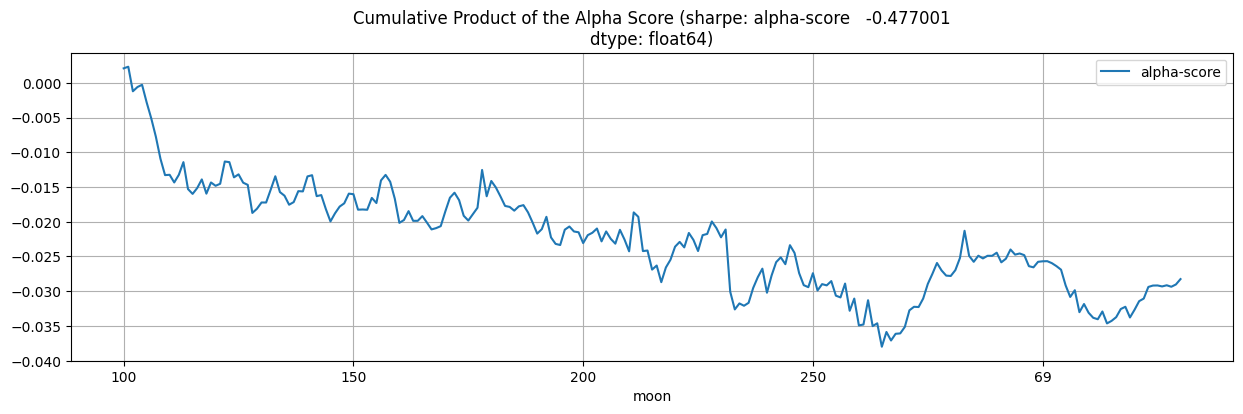

In [ ]:
# Show the cumulative product of the alpha score
cumprod.plot(title=f'Cumulative Product of the Alpha Score (sharpe: {sharpe})', figsize=(15, 4), grid=True)
plt.show()

This vanilla batched boosting estimator doesn't seem to perform here. Try to find a better model!

# Submit your model

## Through the API

In [ ]:
# Save the libraries in a requirements.txt file 
libraries = ['joblib', 'pandas', 'numpy', 'xgboost', 'readwrite', 'tqdm', 'matplotlib']
with open('requirements.txt', 'w') as f:
    for lib in libraries:
        f.write(f"{lib}\n")

In [ ]:
# Convert the notebook to a .py file
!crunch convert --override Quickstarter_datacrunch.ipynb main.py
# Push your code to the platform
!crunch push --message "Quickstarter datacrunch"

convert cell_0 skip since not code: markdown
convert cell_1 skip since not code: markdown
convert cell_2 skip since not code: markdown
convert cell_3 skip since no valid node
convert cell_4 skip since not code: markdown
convert cell_5 skip since not code: markdown
convert cell_6 skip since empty (without !bash, %magic and #comment)
convert cell_7 used 9/9 node(s)
convert cell_8 skip since not code: markdown
convert cell_9 skip since no valid node
convert cell_10 skip since not code: markdown
convert cell_11 skip since not code: markdown
convert cell_12 used 1/1 node(s)
convert cell_13 skip since not code: markdown
convert cell_14 skip since not code: markdown
convert cell_15 used 1/1 node(s)
convert cell_16 skip since not code: markdown
convert cell_17 skip since no valid node
convert cell_18 used 1/1 node(s)
convert cell_19 skip since not code: markdown
convert cell_20 skip since no valid node
convert cell_21 skip since not code: markdown
convert cell_22 skip since no valid node
conve

## Through the website

Deposit this notebook in the submit window of the competition: https://hub.crunchdao.com/competitions/datacrunch/submit/via/notebook